In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
from GWForge.population.redshift import Redshift
import bilby
import numpy as np
import pylab as plt
import os
from glob import glob
import seaborn as sns
import pandas as pd
import dill
from tqdm import tqdm
from scipy.stats import ncx2

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
study_label = 'CE4020ET123_CoBA10_SNR_2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_corrected_td'

In [3]:
gwf_z = Redshift(redshift_model='MadauDickinson', 
                 local_merger_rate_density=22, 
                 maximum_redshift=10, 
                 gps_start_time=0)
gwf_z_prob = gwf_z.coalescence_rate()

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:23

In [4]:
z_grid = np.arange(0, 10, 0.001)
p_z = bilby.core.prior.Interped(z_grid, gwf_z_prob(z_grid))

## Check the probability function against input population

/home/divyajyoti/miniconda3/envs/spe_ngloc_mygwf_mypycbc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


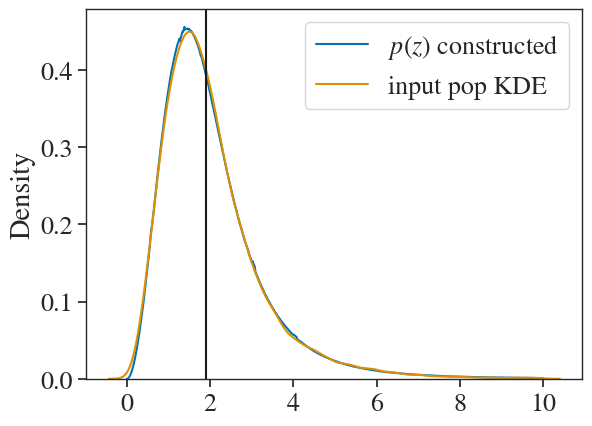

In [5]:
with h5py.File(glob(os.path.join(project_dir, 'input_population', 'BBH', '2_pop*.h5'))[0], 'r') as f:
    input_z = f['redshift'][:]
plt.plot(z_grid, p_z.probability_density(z_grid), label='$p(z)$ constructed')
sns.kdeplot(input_z, label='input pop KDE')
plt.axvline(1.9, c='k')
plt.legend()

## Get SNRs, masses, and redshift

In [19]:
injected_data = {'total':{}}
select_params = ['redshift', 'srcmass1', 'srcmass2', 'srcmtotal']
for det in ['C1', 'CE20', 'E1', 'E2', 'E3', 'network']:
    select_params.append(f'SNR_{det}')
    select_params.append(f'SNR_mf_{det}')
for param in select_params:
    injected_data['total'][param] = []
    for i in range(100):    
        with h5py.File(os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 
                                    'SNR_output_files', 
                                    study_label, 
                                    f'{study_label}_part{i}_SNR_data.h5'), 'r') as f:
            injected_data['total'][param].append(f['results'][param][:])
    injected_data['total'][param] = np.concatenate(injected_data['total'][param])

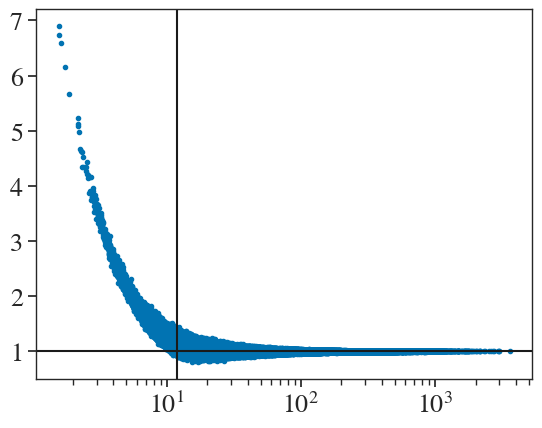

In [20]:
plt.plot(injected_data['total']['SNR_network'], 
         injected_data['total']['SNR_mf_network']/injected_data['total']['SNR_network'], '.')
plt.xscale('log')
plt.axvline(12, color='k')
plt.axhline(1, color='k')

In [21]:
len(injected_data['total']['redshift'])

1000000

### Calculate MF SNRs from Optimal SNRs

In [22]:
def mf_snr_from_opt_snr(opt_snr, method='chisq'):
    """
    Choose method from ['chisq', 'normal']
    """
    if method == 'normal':
        mf_snr = np.random.normal(loc=opt_snr, scale=1.0)
    elif method == 'chisq':
        mf_snr_sq = ncx2.rvs(2, opt_snr**2)
        mf_snr = np.sqrt(mf_snr_sq)
    return(mf_snr)

In [23]:
#dets = ['L1', 'H1', 'I1']
dets = ['C1', 'CE20', 'E1', 'E2', 'E3']
for det in dets:
    injected_data['total'][f'SNR_mf_from_opt_{det}'] = []
injected_data['total']['SNR_mf_from_opt_network'] = []

for event in tqdm(range(len(injected_data['total']['SNR_network']))):
    snr_netw_sq = 0
    for det in dets:
        snr_det = mf_snr_from_opt_snr(injected_data['total'][f'SNR_{det}'][event])
        injected_data['total'][f'SNR_mf_from_opt_{det}'].append(snr_det)
        snr_netw_sq += snr_det**2
    injected_data['total']['SNR_mf_from_opt_network'].append(np.sqrt(snr_netw_sq))

for key in injected_data['total'].keys():
    if 'mf_from_opt' in key:
        injected_data['total'][key] = np.array(injected_data['total'][key])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [03:37<00:00, 4604.71it/s]


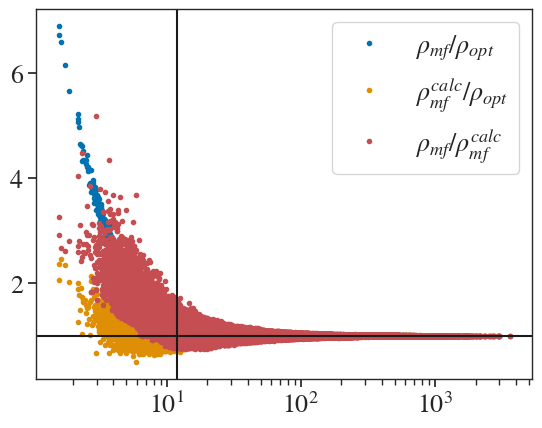

In [24]:
plt.plot(injected_data['total']['SNR_network'], 
         injected_data['total']['SNR_mf_network']/injected_data['total']['SNR_network'], 
         '.', label='$\\rho_{mf}/\\rho_{opt}$')
plt.plot(injected_data['total']['SNR_network'], 
         injected_data['total']['SNR_mf_from_opt_network']/injected_data['total']['SNR_network'], 
         '.', label='$\\rho_{mf}^{calc}/\\rho_{opt}$')
plt.plot(injected_data['total']['SNR_network'], 
         injected_data['total']['SNR_mf_network']/injected_data['total']['SNR_mf_from_opt_network'], 
         '.', label='$\\rho_{mf}/\\rho_{mf}^{calc}$', color='r')
plt.xscale('log')
plt.axvline(12, color='k')
plt.axhline(1, color='k')
plt.legend(loc=1)

## Get detected population for injections

In [25]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, 
                      method='network', return_detected_dict=False, 
                      snr_type='mf_from_opt'):
    if type(data_dict) == pd.core.frame.DataFrame:
        pass
    else:
        data_dict = pd.DataFrame(data_dict)
        
    if snr_type == 'opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR' in key and 'mf' not in key]
    elif snr_type == 'mf_from_opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf_from_opt' in key]
    elif snr_type == 'mf':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf' in key and 'from_opt' not in key]
    else:
        raise KeyError('Please choose snr_type from "opt" or "mf"')
    print(SNR_keys)
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        if snr_type == 'opt':
            dict_key = key.split('SNR_')[-1]
        elif snr_type == 'mf_from_opt':
            dict_key = key.split('SNR_mf_from_opt_')[-1]
        elif snr_type == 'mf':
            dict_key = key.split('SNR_mf_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [26]:
injected_data['detected'] = get_detected_SNRs(injected_data['total'], method='two-detector', snr_type='opt')
injected_data['detected_mf'] = get_detected_SNRs(injected_data['total'], method='two-detector', snr_type='mf')
injected_data['detected_mf_from_opt'] = get_detected_SNRs(injected_data['total'], method='two-detector', snr_type='mf_from_opt')

['SNR_C1', 'SNR_CE20', 'SNR_E1', 'SNR_E2', 'SNR_E3', 'SNR_network']
['SNR_mf_C1', 'SNR_mf_CE20', 'SNR_mf_E1', 'SNR_mf_E2', 'SNR_mf_E3', 'SNR_mf_network']
['SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network']


In [27]:
len(injected_data['detected']['redshift']), len(injected_data['detected_mf']['redshift']), len(injected_data['detected_mf_from_opt']['redshift'])

(957532, 979541, 960720)

## Create gwpopulation injection prior for redshift

In [38]:
injected_data['detected']['p_z'] = p_z.probability_density(injected_data['detected']['redshift'])
injected_data['detected_mf']['p_z'] = p_z.probability_density(injected_data['detected_mf']['redshift'])
injected_data['detected_mf_from_opt']['p_z'] = p_z.probability_density(injected_data['detected_mf_from_opt']['redshift'])

/home/divyajyoti/miniconda3/envs/spe_ngloc_mygwf_mypycbc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/divyajyoti/miniconda3/envs/spe_ngloc_mygwf_mypycbc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/divyajyoti/miniconda3/envs/spe_ngloc_mygwf_mypycbc/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, '$z$')

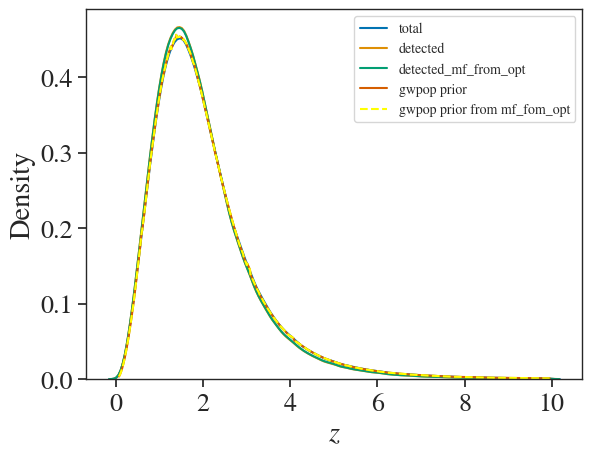

In [40]:
sns.kdeplot(injected_data['total']['redshift'], label='total')
sns.kdeplot(injected_data['detected']['redshift'], label='detected')
sns.kdeplot(injected_data['detected_mf_from_opt']['redshift'], label='detected_mf_from_opt')
sort_idx = np.argsort(injected_data['detected']['redshift'])
plt.plot(np.array(injected_data['detected']['redshift'])[sort_idx], 
         np.array(injected_data['detected']['p_z'])[sort_idx], label='gwpop prior')
sort_idx_mf = np.argsort(injected_data['detected_mf_from_opt']['redshift'])
plt.plot(np.array(injected_data['detected_mf_from_opt']['redshift'])[sort_idx_mf], 
         np.array(injected_data['detected_mf_from_opt']['p_z'])[sort_idx_mf], label='gwpop prior from mf_fom_opt', ls='--', c='yellow')
plt.legend(loc=1, fontsize=10)
plt.xlabel('$z$')

### Divide injections into mass bands

In [41]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

In [42]:
injected_data['detected_mf_from_opt'].keys()

Index(['redshift', 'srcmass1', 'srcmass2', 'srcmtotal', 'SNR_C1', 'SNR_mf_C1',
       'SNR_CE20', 'SNR_mf_CE20', 'SNR_E1', 'SNR_mf_E1', 'SNR_E2', 'SNR_mf_E2',
       'SNR_E3', 'SNR_mf_E3', 'SNR_network', 'SNR_mf_network',
       'SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1',
       'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network',
       'p_z'],
      dtype='object')

In [48]:
mass_ranges = ['<20', '20-60', '60-100', '>100']
injected_data['mass_select'] = {}
print('Total detected events =', len(injected_data['detected_mf_from_opt']))
for m_range in mass_ranges:
    print(m_range)
    injected_data['mass_select'][m_range] = {'detected_mf_from_opt': injected_data['detected_mf_from_opt'][slice_mtotal_pop(injected_data['detected_mf_from_opt']['srcmtotal'], m_range)]}
    injected_data['mass_select'][m_range]['total'] = pd.DataFrame(injected_data['total'])[slice_mtotal_pop(injected_data['total']['srcmtotal'], m_range)]
    print('Total =', len(injected_data['mass_select'][m_range]['total']))
    print('Detected =', len(injected_data['mass_select'][m_range]['detected_mf_from_opt']), '\n')

Total detected events = 960720
<20
Total = 608356
Detected = 571719 

20-60
Total = 336184
Detected = 333556 

60-100
Total = 51455
Detected = 51441 

>100
Total = 4005
Detected = 4004 



## Write to file

#### Optimal SNR detected population

In [125]:
z_dict_write = {'redshift':np.array(injected_data['detected']['redshift']), 
                'prior':np.array(injected_data['detected']['p_z']),
                'total_generated':len(injected_data['total']['redshift'])}

In [126]:
z_dict_write

{'redshift': array([0.60420558, 1.15718353, 1.36790472, ..., 0.64030051, 1.32739309,
        1.5062418 ]),
 'prior': array([0.20164625, 0.42679907, 0.45821708, ..., 0.21798621, 0.45465871,
        0.4585973 ]),
 'total_generated': 1000000}

In [77]:
with open(os.path.join(project_dir, 'gwpopulation', 'BBH', 'detected_injections.pkl'), 'wb') as f:
    dill.dump(z_dict_write, f)

#### MF SNR detected population

In [15]:
z_dict_write_mf = {'redshift':np.array(injected_data['detected_mf']['redshift']), 
                'prior':np.array(injected_data['detected_mf']['p_z']),
                'total_generated':len(injected_data['total']['redshift'])}

In [16]:
z_dict_write_mf

{'redshift': array([3.84079076, 1.04644887, 0.86221836, ..., 1.39134291, 1.52781983,
        2.11487193]),
 'prior': array([0.06591428, 0.39069246, 0.32101525, ..., 0.45236422, 0.45093994,
        0.34119665]),
 'total_generated': 1000000}

In [17]:
with open(os.path.join(project_dir, 'gwpopulation', 'BBH', f'{study_label}_detected_injs_mf_SNR_1M_points.pkl'), 'wb') as f:
    dill.dump(z_dict_write_mf, f)

#### MF from opt SNR detected population

In [49]:
z_dict_write_mf_from_opt = {}
for m_range in mass_ranges:
    z_dict_write_mf_from_opt[m_range] = {'redshift':np.array(injected_data['mass_select'][m_range]['detected_mf_from_opt']['redshift']), 
                                         'prior':np.array(injected_data['mass_select'][m_range]['detected_mf_from_opt']['p_z']),
                                         'total_generated':len(injected_data['mass_select'][m_range]['total']['redshift'])}

In [50]:
z_dict_write_mf_from_opt

{'<20': {'redshift': array([3.84079076, 0.86221836, 0.95576421, ..., 1.77667738, 1.52781983,
         2.11487193]),
  'prior': array([0.06591428, 0.32101525, 0.35942351, ..., 0.41850998, 0.45093994,
         0.34119665]),
  'total_generated': 608356},
 '20-60': {'redshift': array([1.04644887, 1.03075576, 0.80003142, ..., 1.62321591, 1.19106021,
         1.39134291]),
  'prior': array([0.39069246, 0.38617555, 0.29384174, ..., 0.44271303, 0.42768654,
         0.45236422]),
  'total_generated': 336184},
 '60-100': {'redshift': array([4.9956343 , 2.89417961, 2.307413  , ..., 0.67112664, 1.37592129,
         1.70680194]),
  'prior': array([0.02315916, 0.16959954, 0.29228824, ..., 0.23116177, 0.45382861,
         0.43118906]),
  'total_generated': 51455},
 '>100': {'redshift': array([1.98958438, 3.58838031, 1.99310612, ..., 2.97128258, 2.79882636,
         0.83127042]),
  'prior': array([0.37206227, 0.08446339, 0.37120704, ..., 0.15584239, 0.18489082,
         0.3077069 ]),
  'total_generate

In [51]:
def mass_range_names(range_name):
    return(range_name.replace('<', 'below_').replace('>', 'above_'))

In [56]:
for m_range in mass_ranges:
    num_points = z_dict_write_mf_from_opt[m_range]['total_generated']
    m_range_name = mass_range_names(m_range)
    write_dir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'injections', 'mass_bands')
    os.makedirs(write_dir, exist_ok=True)
    with open(os.path.join(write_dir,
                           f'{study_label}_detected_injs_mf_from_opt_SNR_{num_points}_points_{m_range_name}.pkl'), 
              'wb') as f:
        dill.dump(z_dict_write_mf_from_opt[m_range], f)